In [1]:
import sys
sys.path.insert(1, 'functions/')
from ipynb.fs.full.interpolation_functions import *
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

## read fesom data

In [4]:
###### levante #####
mesh_path = '/work/ab0995/a270185/meshes/AO_40/fesom.mesh.diag.nc'


##### juwels #####
#mesh_path = '/p/largedata/hhb19/li1/scratch_backup/AWI-Mesh1/A0_40_1km_mesh/fesom.mesh.diag.nc'

In [5]:
fesom_mesh = xr.open_dataset(mesh_path)

model_lon = fesom_mesh.lon.values
model_lat = fesom_mesh.lat.values

In [7]:
##### levante #####
si_path = '/work/ab0995/a270185/AO_1km_ice/'
#save_in_path = '/work/bk1377/a270230/data/interpolated_fesom_output/'

##### juwels #####
### 2013-2020 ###
#si_path = '/p/largedata/hhb19/li1/scratch_backup/fesom2_runs_2023_newVersion/3fesom2_farc_AWICM_KPP_forcingCorrect_MakeRelaxsalt_new_2010/results/'
### 2093 - 2100 ###
#si_path = '/p/largedata/hhb19/li1/scratch_backup/fesom2_runs_2023_newVersion/3fesom2_farc_AWICM_KPP_forcingCorrect_MakeRelaxsalt_new_2090_chhb19/results/'

save_in_path = '/p/project/chhb19/gaertner2/data/interpolated_fesom_output/'

In [5]:
years = [2014]

In [6]:
for year in years:
    
    ##### load the data #####
    
    a_ice = xr.open_dataset(si_path + f'a_ice.fesom.{year}.nc').a_ice
    u_ice = xr.open_dataset(si_path + f'uice.fesom.{year}.nc').uice
    v_ice = xr.open_dataset(si_path + f'vice.fesom.{year}.nc').vice
    
    ntimesteps = len(a_ice.time)
    startday = 0
    save_as_name = save_in_path + f'ice_{year}.nc'
    
    ##### interpolate and create nc file #####
    
    # create interpolation grid
    box = (-180, 180, 70, 90)
    res = (1000, 1000)
    proj = 'np'
    int_x_steps, int_y_steps, int_lons, int_lats = region_cartopy(box, res, proj)

    # calculate distance to and index of the fesom grid point closest to
    # the grid point in the interpolation grid
    distances, inds = create_indexes_and_distances(model_lon, model_lat,
                                                   int_lons, int_lats,
                                                   k=1, workers=10)

    # do the nearest neighbor interpolation
    a_ice_int, u_ice_int, v_ice_int = interpolate(
        a_ice[startday:], u_ice[startday:], v_ice[startday:], inds, distances,
        ntimesteps, shape = int_lons.shape
    )

    create_nc_file(a_ice_int, u_ice_int, v_ice_int, int_lons, int_lats, ntimesteps,
               save_as_name)

FileNotFoundError: [Errno 2] No such file or directory: b'/work/ab0995/a270185/AO_1km_ice/a_ice.fesom.2014.nc'

## read fesom data eerie catalogue

In [2]:
eerie_cat = intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")

In [3]:
data = eerie_cat['dkrz.disk.model-output.ifs-fesom2-sr.eerie-control-1950.ocean.native']['daily'].to_dask()

In [4]:
grid = eerie_cat['dkrz.disk.model-output.ifs-fesom2-sr.eerie-control-1950.ocean.native']['node_grid'].to_dask()
model_lon = grid.grid_center_lon.values
model_lat = grid.grid_center_lat.values
model_lon = np.where(model_lon>180, model_lon-360, model_lon)

In [6]:
# the data object contains data from 1950-01-01 to 1956-12-31. set
# startday and ntimesteps accordingly

ntimesteps = 10
startday = 0
a_ice = data.a_ice
u_ice = data.uice
v_ice = data.vice
save_in_path = '/work/bk1377/a270230/'
save_as_name = save_in_path + 'ice_fesom_1950.nc'

## read icon data

In [20]:
data = eerie_cat["dkrz"]["disk"]["model-output"]["icon-esm-er"]["eerie-control-1950"]["ocean"]["native"]["2d_daily_mean"].to_dask()

In [92]:
grid = xr.open_dataset("/pool/data/ICON/grids/public/mpim/0016/icon_grid_0016_R02B09_O.nc", chunks="auto")
model_lon = grid.clon.values*180./np.pi
model_lat = grid.clat.values*180/np.pi

In [93]:
ntimesteps = 365
startday = 0
a_ice = data.conc[:,0,:]
u_ice = data.ice_u
v_ice = data.ice_v
save_in_path = '/work/bk1377/a270230/'
save_as_name = save_in_path + 'ice_icon_2002.nc'

## read nemo data

In [2]:
nextgems_cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")

In [3]:
data = nextgems_cat.IFS['IFS_9-NEMO_25-cycle3']['2D_1h_native'].to_dask()

In [4]:
model_lon = data.lon
model_lat = data.lat

In [5]:
ntimesteps = 5 # one year: 347*24 
startday = 0
a_ice = data['2t']
u_ice = data['10u']
v_ice = data['10v']
save_in_path = '/work/bk1377/a270230/'
save_as_name = save_in_path + 'ice_nemo.nc'

## interpolate and save as nc file

In [34]:
# create interpolation grid
box = (-180, 180, 70, 90)
res = (1000, 1000)
proj = 'np'
int_x_steps, int_y_steps, int_lons, int_lats = region_cartopy(box, res, proj)

# calculate distance to and index of the fesom grid point closest to
# the grid point in the interpolation grid
distances, inds = create_indexes_and_distances(model_lon, model_lat,
                                               int_lons, int_lats,
                                               k=1, workers=10)

# do the nearest neighbor interpolation
a_ice_int, u_ice_int, v_ice_int = interpolate(
    a_ice[startday:], u_ice[startday:], v_ice[startday:], inds, distances,
    ntimesteps, shape = int_lons.shape
)

create_nc_file(a_ice_int, u_ice_int, v_ice_int, int_lons, int_lats, ntimesteps,
           save_as_name)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360


## plot the interpolated data

/p/project/chhb19/gaertner2/jupyter/kernels/gaertner2_interpolation/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


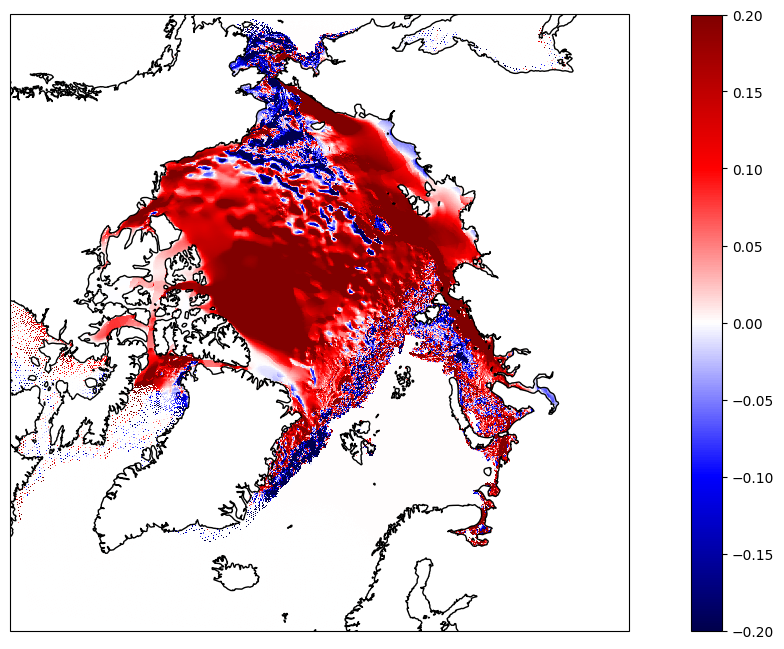

In [24]:
test = xr.open_dataset(save_as_name)

fig = plt.figure(figsize=[16, 8])
ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
ax.coastlines(zorder=3)
im = ax.pcolormesh(test.ULON, test.ULAT,
                   test.U.isel(time=-1),
                   cmap = 'seismic',
                   vmin=-0.2,vmax=0.2,
                   transform=ccrs.PlateCarree())
plt.colorbar(im)